# Westeros Tutorial Part II - Introducing emissions

In the first part, the model chose not base the power system on wind power as electricity from  wind turbines was more expensive than electricity produced from coal. However, now we introduce emissions to investigate the impact of climate policy. Let's see what happens then.

In [1]:
import pandas as pd
import ixmp
import message_ix

from message_ix.utils import make_df

%matplotlib inline

In [2]:
mp = ixmp.Platform(dbtype='HSQLDB')

INFO:root:launching ixmp.Platform with local HSQLDB database at '/Users/BintangYuwono/.local/share/ixmp/localdbdefault'


In [3]:
model = 'Westeros Electrified'

base = message_ix.Scenario(mp, model=model, scenario='baseline')
scen_emsbound = base.clone(model, 'emission_bound','introducing an upper bound on emissions',
                  keep_solution=False)
scen_emsbound.check_out()

In [4]:
year_df = scen_emsbound.vintage_and_active_years()
vintage_years, act_years = year_df['year_vtg'], year_df['year_act']
model_horizon = scen_emsbound.set('year')
country = 'Westeros'

## Introducing Emissions

In [5]:
# first we introduce the emission specis CO2 and the emission category GHG
scen_emsbound.add_set('emission', 'CO2')
scen_emsbound.add_cat('emission', 'GHG', 'CO2')

# we now add CO2 emissions to the coal powerplant
base_emission = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'unit': 'kg/kWa',
}

# units: tCO2/MWh
tec = {
    'coal_ppl',
    'gas_ppl',
}
emissions = {
    'coal_ppl': ('CO2', 85.4),
    'gas_ppl':  ('CO2', 33.9),
}

for tec, (species, val) in emissions.items():
    df = make_df(base_emission, technology=tec, emission=species, value=val)
    scen_emsbound.add_par('emission_factor', df)
    

## Define a Bound on Emissions

The `type_year: cumulative` assigns an upper bound on the *average emissions per year* over the entire time horizon.

In [6]:
scen_emsbound.add_par('bound_emission', key=[country, 'GHG', 'all', 'cumulative'],
             val=8000., unit='tCO2')

## Time to Solve the Model

In [7]:
scen_emsbound.commit(comment='introducing emissions and setting an upper bound')
scen_emsbound.set_as_default()

In [8]:
scen_emsbound.solve()

In [9]:
scen_emsbound.var('OBJ')['lvl']

401779.84375

## Plotting Results

In [10]:
from tools import Plots
p = Plots(scen_emsbound, country, firstyear=700)

### Activity

How much energy is generated in each time period from the different potential sources?

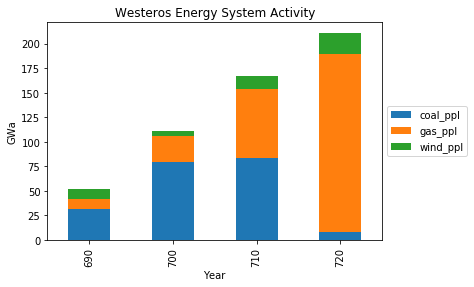

In [11]:
p.plot_activity(baseyear=True, subset=['coal_ppl', 'gas_ppl', 'wind_ppl'])

### Capacity

Given how many new plants are built, how many are actually used?

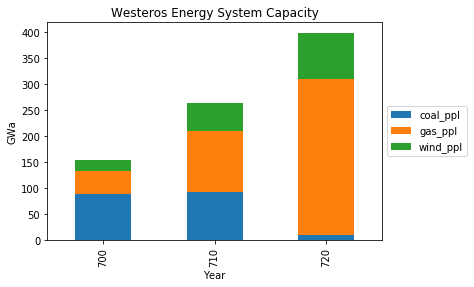

In [12]:
p.plot_capacity(baseyear=True, subset=['coal_ppl', 'gas_ppl', 'wind_ppl'])

### Electricity Price

And how much does the electricity cost? These prices are taken from the **dual variables** of the solution and are given the name **shadow prices**. They reflect the marginal price of electricity, taken from the most expensive producer.  

Note that the price drop when the most expensive technology is no longer in the system.

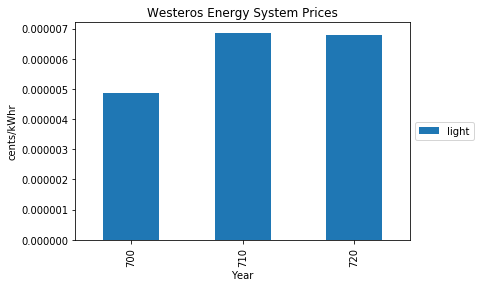

In [13]:
p.plot_prices(subset=['light'], baseyear=True)

## Close the connection to the database

In [14]:
mp.close_db()